# W207-1 Final Project - "Random Acts of Pizza"

## Team
- Andrew Mamroth
- Colby Carter
- Matt Adereth
- Rob Deng

[Team Github](https://github.com/mamrotha/2017_Fall_207_KaggleProj)

## Overview

[Original Kaggle Description](https://www.kaggle.com/c/random-acts-of-pizza)

There is a sub-reddit called [r/Random_Acts_Of_Pizza](https://www.reddit.com/r/Random_Acts_Of_Pizza/) where users can post requests for someone to purchase them a pizza and, shockingly, random internet strangers will then buy them pizza.  In this competition, we are provided with a data set containing over 5,000 posts from this sub-reddit and our goal is to build a model that can predict whether or not the post will result in a pizza purchase.

# Package Initialization

In [42]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import *
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

# ADD METRICS
from sklearn import metrics
from sklearn.metrics import classification_report

#NLTK - NLP Tokenizing and Cleaning
import nltk
from nltk import pos_tag, pos_tag_sents
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#GMM
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture

In [2]:
# Only evaluate this if you don't already have the NLTK corpora
#nltk.download()

# Data 

## Original description of the data from the Kaggle website

This dataset includes 5671 requests collected from the Reddit community Random Acts of Pizza between December 8, 2010 and September 29, 2013 (retrieved on September 30, 2013). All requests ask for the same thing: a free pizza. The outcome of each request -- whether its author received a pizza or not -- is known. Meta-data includes information such as: time of the request, activity of the requester, community-age of the requester, etc.

Each JSON entry corresponds to one request (the first and only request by the requester on Random Acts of Pizza). We have removed fields from the test set which would not be available at the time of posting.

### Field Descriptions

| Field Name | Description |
| ---------- | ----------- |
| giver_username_if_known | Reddit username of giver if known, i.e. the person satisfying the request ("N/A" otherwise). |
| number_of_downvotes_of_request_at_retrieval | Number of downvotes at the time the request was collected. |
| number_of_upvotes_of_request_at_retrieval | Number of upvotes at the time the request was collected. |
| post_was_edited | Boolean indicating whether this post was edited (from Reddit). |
| request_id | Identifier of the post on Reddit, e.g. "t3_w5491". |
| request_number_of_comments_at_retrieval | Number of comments for the request at time of retrieval. |
| request_text | Full text of the request. |
| request_text_edit_aware | Edit aware version of "request_text". We use a set of rules to strip edited comments indicating the success of the request such as "EDIT: Thanks /u/foo, the pizza was delicous". |
| request_title | Title of the request. |
| requester_account_age_in_days_at_request | Account age of requester in days at time of request. |
| requester_account_age_in_days_at_retrieval | Account age of requester in days at time of retrieval. |
| requester_days_since_first_post_on_raop_at_request | Number of days between requesters first post on RAOP and this request (zero if requester has never posted before on RAOP). |
| requester_days_since_first_post_on_raop_at_retrieval | Number of days between requesters first post on RAOP and time of retrieval. |
| requester_number_of_comments_at_request | Total number of comments on Reddit by requester at time of request. |
| requester_number_of_comments_at_retrieval | Total number of comments on Reddit by requester at time of retrieval. |
| requester_number_of_comments_in_raop_at_request | Total number of comments in RAOP by requester at time of request. |
| requester_number_of_comments_in_raop_at_retrieval | Total number of comments in RAOP by requester at time of retrieval. |
| requester_number_of_posts_at_request | Total number of posts on Reddit by requester at time of request. |
| requester_number_of_posts_at_retrieval | Total number of posts on Reddit by requester at time of retrieval. |
| requester_number_of_posts_on_raop_at_request | Total number of posts in RAOP by requester at time of request. |
| requester_number_of_posts_on_raop_at_retrieval | Total number of posts in RAOP by requester at time of retrieval. |
| requester_number_of_subreddits_at_request | The number of subreddits in which the author had already posted in at the time of request. |
| requester_received_pizza | Boolean indicating the success of the request, i.e., whether the requester received pizza. |
| requester_subreddits_at_request | The list of subreddits in which the author had already posted in at the time of request. |
| requester_upvotes_minus_downvotes_at_request | Difference of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_minus_downvotes_at_retrieval | Difference of total upvotes and total downvotes of requester at time of retrieval. |
| requester_upvotes_plus_downvotes_at_request | Sum of total upvotes and total downvotes of requester at time of request. |
| requester_upvotes_plus_downvotes_at_retrieval | Sum of total upvotes and total downvotes of requester at time of retrieval. |
| requester_user_flair | Users on RAOP receive badges (Reddit calls them flairs) which is a small picture next to their username. In our data set the user flair is either None (neither given nor received pizza, N=4282), "shroom" (received pizza, but not given, N=1306), or "PIF" (pizza given after having received, N=83). |
| requester_username | Reddit username of requester. |
| unix_timestamp_of_request | Unix timestamp of request (supposedly in timezone of user, but in most cases it is equal to the UTC timestamp -- which is incorrect since most RAOP users are from the USA). |
| unix_timestamp_of_request_utc | Unit timestamp of request in UTC. |

## Initial Loading

In [3]:
# Load raw data and create labels
raw_train = pd.read_json('./data/train.json')
raw_test = pd.read_json('./data/test.json')

print("Raw Train Shape:", raw_train.shape)
print("Raw Test Shape:", raw_test.shape)

Raw Train Shape: (4040, 32)
Raw Test Shape: (1631, 17)


## Schema Reconciliation

The training data has 32 columns, while the test data only has 17.  Let's look at which columns are different:

In [4]:
raw_train_only_columns = set(raw_train.columns.values) - set(raw_test.columns.values)

if len(raw_train_only_columns) > 0:
    print ("Columns in Train but not Test:")
    for c in raw_train_only_columns:
        print (" ", c)
else:
    print ("No columns in Train but not Test")
    
raw_test_only_columns = set(raw_test.columns.values) - set(raw_train.columns.values)
print("")
if len(raw_test_only_columns) > 0:
    print ("Columns in Test but not Train:")
    for c in raw_test_only_columns:
        print (" ", c)
else:
    print ("No columns in Test but not Train")

Columns in Train but not Test:
  request_text
  requester_number_of_comments_at_retrieval
  request_number_of_comments_at_retrieval
  requester_received_pizza
  number_of_downvotes_of_request_at_retrieval
  requester_number_of_posts_at_retrieval
  post_was_edited
  requester_number_of_posts_on_raop_at_retrieval
  requester_user_flair
  requester_days_since_first_post_on_raop_at_retrieval
  requester_upvotes_plus_downvotes_at_retrieval
  requester_upvotes_minus_downvotes_at_retrieval
  requester_number_of_comments_in_raop_at_retrieval
  number_of_upvotes_of_request_at_retrieval
  requester_account_age_in_days_at_retrieval

No columns in Test but not Train


There are several columns that aren't included in the test data and thus need to be excluded from the training data.

- \*_at_retrival - These are features that are dependent on when the data was pulled.  For real-time prediction when a post is made, these are not relevant since they will be the same as their \*_at_request counterparts
- post_was_edited - Since users are supposed to edit their post if they receive a pizza, this would be a major leak of results.  Additionally, we want to be able to make predictions as soon as the post is made, so subsequent edits won't be available.
- requester_user_flair - There isn't historical flair information, so this feature isn't an accurate reflection of the state at the time of the request.  Users who successfully give or receive pizza are granted special flair, so this would also be an unfair indicator of results.
- request_text - Since successful posts are often edited to indicate that the request has been fulfilled, the full request_text can't be used.  The additional "request_text_edit_aware" field has edits stripped out and is available in both the train and test data and will be used instead.

In [5]:
train_with_test_schema = raw_train[raw_test.columns.values]

## Train/Development Data Split

We'll hold out ~15% of the training data as our development data set.  All exploratory data analysis and model training will be done only on the ~85% of training data that is not being held out.  We do not know if the order of the training data is meaningful, so we will use random sampling to avoid introducing bias.

In [6]:
np.random.seed(6)
in_dev = np.random.choice([True, False], len(raw_train), p=[0.15, 0.85])

# train_data will be the training data without any new features added.  This will be used for the EDA.
train_data = train_with_test_schema[np.logical_not(in_dev)].copy()

train_labels = raw_train["requester_received_pizza"][np.logical_not(in_dev)]
dev_labels = raw_train["requester_received_pizza"][in_dev]

# We will add new features to extended_data as we explore.  When we complete, we will set the train_data, dev_data, 
# and test_data to be the appropriate rows from extended_data.
extended_data = pd.concat([train_with_test_schema.copy(), raw_test])
in_train = np.concatenate((np.logical_not(in_dev), np.full(len(raw_test), False)))
in_dev = np.concatenate((in_dev, np.full(len(raw_test), False)))
in_test = np.concatenate((np.full(len(raw_train), False), np.full(len(raw_test), True)))

## Exploratory Data Analysis
We'll now look at the individual fields to understand their types and distributions.

### Request Time
There are several things to look at with respect to the request time:

1. Has the frequency of requests changed over time?
2. Has the rate of request fulfillment changed over time?
3. Does day of week matter? (Possible new feature)
4. Does time of day matter? (Possible new feature)

#### Request Frequency

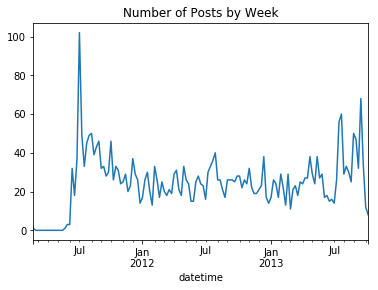

In [7]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_data["unix_timestamp_of_request"], unit = 's')
d.index = d['datetime']
d['datetime'].resample('W').count().plot().set_title('Number of Posts by Week')

#### Request Fulfillment over Time

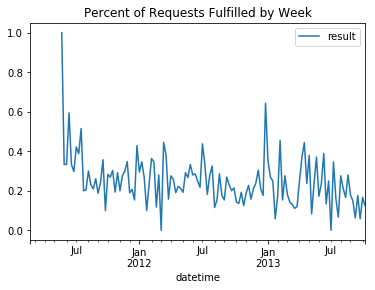

In [8]:
d = pd.DataFrame()
d['datetime'] = pd.to_datetime(train_data["unix_timestamp_of_request"], unit = 's')
d['result'] = train_labels
d.index = d['datetime']
d.resample('W').mean().plot().set_title("Percent of Requests Fulfilled by Week")

It looks like there was a lot of excitement at the start of the sub-reddit.  There was a burst of requests and an unsustained high rate of fulfillment.  We will add a feature that indicates whether or not the post was during this initial time, since it doesn't seem to be a part of the general trend.  August 1st, 2011 looks like a reasonable cutoff, so there will be a new boolean feature called "during_initial_period" that indicates this.

In [9]:
import time
import datetime
cutoff_date = datetime.date(2011,8,1)
cutoff_time = time.mktime(cutoff_date.timetuple())
extended_data['during_initial_period'] = np.where(extended_data['unix_timestamp_of_request_utc'] < cutoff_time, 1, 0)

#### Day of Week

In [10]:
d['dayofweek'] = d['datetime'].dt.dayofweek
d.groupby('dayofweek').agg(['mean', 'count'])

result      
               mean count
dayofweek                
0          0.253521   497
1          0.230315   508
2          0.217241   580
3          0.296375   469
4          0.265351   456
5          0.230088   452
6          0.230769   481

#### Time of Day

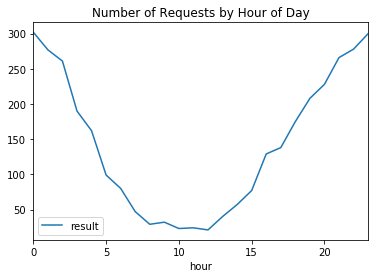

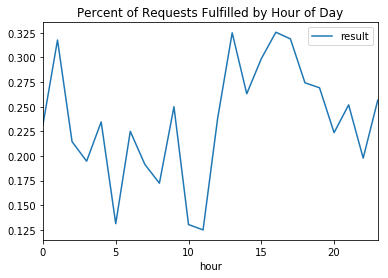

In [11]:
d['hour'] = d['datetime'].dt.hour
d[['hour', 'result']].groupby('hour').agg('count').plot().set_title("Number of Requests by Hour of Day")
d[['hour', 'result']].groupby('hour').agg('mean').plot().set_title("Percent of Requests Fulfilled by Hour of Day")

The fulfillment rate varies from 21.1% to 28.8% by the day of the week and from 11.1% to 39.0% depending on the hour of the day. Both of these seem like reasonably distinguishing features that we should include.

In [12]:
extended_data['day_of_week'] = pd.to_datetime(extended_data["unix_timestamp_of_request"], unit = 's').dt.dayofweek
extended_data['hour_of_day'] = pd.to_datetime(extended_data["unix_timestamp_of_request"], unit = 's').dt.hour

### Field Comparison Utilities

In [13]:
from scipy.stats import ttest_ind

def success_vs_fail_report(feature, try_log = False):
    print (feature)
    success_values = train_data[feature][train_labels]
    print ("SUCCESS", "Mean:", "{:.3f}".format(success_values.mean()), "StdDev:", "{:.3f}".format(success_values.std()))
    fail_values = train_data[feature][np.logical_not(train_labels)]
    print ("FAIL   ", "Mean:", "{:.3f}".format(fail_values.mean()), "StdDev:", "{:.3f}".format(fail_values.std()))
    ttest = ttest_ind(success_values, fail_values, equal_var=False)
    print ("TStat:", "{:.3f}".format(ttest.statistic))
    
    if try_log:
        ttest_of_log = ttest_ind(np.log(success_values + 1), np.log(fail_values + 1), equal_var=False)
        print ("TStat (log):", "{:.3f}".format(ttest_of_log.statistic))
    

### Text Field Lengths
#### Title Length

In [14]:
train_data['title_length'] = train_data['request_title'].str.len()
success_vs_fail_report('title_length', try_log=True)

title_length
SUCCESS Mean: 73.527 StdDev: 37.051
FAIL    Mean: 71.085 StdDev: 35.765
TStat: 1.678
TStat (log): 2.099


#### Request Length

In [15]:
train_data['request_length'] = train_data['request_text_edit_aware'].str.len()
success_vs_fail_report('request_length', try_log=True)

request_length
SUCCESS Mean: 466.801 StdDev: 388.117
FAIL    Mean: 371.984 StdDev: 347.083
TStat: 6.324
TStat (log): 6.540


It seems that the title length doesn't seem to vary much for those who received a pizza vs those that did not.  However, it does appear that a longer request is much more likely to get you a pizza.  This is a very good feature to include in the model.

In [16]:
extended_data['request_length'] = extended_data['request_text_edit_aware'].str.len()

### Upvotes vs Downvotes

Here we compare using the features requester_upvotes_minus_downvotes_at_request and requester_upvotes_plus_downvotes_at_request vs creating new features 'upvotes' and 'downvotes'

In [17]:
success_vs_fail_report('requester_upvotes_minus_downvotes_at_request')  #Not doing log because this can be negative

print()
success_vs_fail_report('requester_upvotes_plus_downvotes_at_request', try_log=True)

print()
train_data['upvotes']  = (train_data['requester_upvotes_minus_downvotes_at_request'] +
                       train_data['requester_upvotes_plus_downvotes_at_request']) / 2
success_vs_fail_report('upvotes', try_log=True)

print()
train_data['downvotes']  = (train_data['requester_upvotes_plus_downvotes_at_request'] +
                       train_data['upvotes'])
success_vs_fail_report('downvotes', try_log=True)

print()
train_data['upvotes_ratio']  = np.nan_to_num(train_data['upvotes'] / train_data['requester_upvotes_plus_downvotes_at_request'], 0)
success_vs_fail_report('upvotes_ratio')

requester_upvotes_minus_downvotes_at_request
SUCCESS Mean: 1384.634 StdDev: 5722.983
FAIL    Mean: 1099.245 StdDev: 3111.062
TStat: 1.384

requester_upvotes_plus_downvotes_at_request
SUCCESS Mean: 5189.639 StdDev: 45467.228
FAIL    Mean: 3412.276 StdDev: 18660.821
TStat: 1.106
TStat (log): 7.138

upvotes
SUCCESS Mean: 3287.136 StdDev: 25527.129
FAIL    Mean: 2255.761 StdDev: 10711.807
TStat: 1.142
TStat (log): 7.172

downvotes
SUCCESS Mean: 8476.775 StdDev: 70988.942
FAIL    Mean: 5668.037 StdDev: 29355.211
TStat: 1.119
TStat (log): 7.297

upvotes_ratio
SUCCESS Mean: 0.670 StdDev: 0.255
FAIL    Mean: 0.597 StdDev: 0.316
TStat: 6.753


Both the upvotes_ratio and log(upvotes + 1) are very strong indicators, so they should also be included as a new feature.

In [18]:
extended_data['upvotes'] = (extended_data['requester_upvotes_minus_downvotes_at_request'] +
                            extended_data['requester_upvotes_plus_downvotes_at_request']) / 2

extended_data['upvotes_log'] = np.log(extended_data['upvotes'] + 1)

extended_data['upvotes_ratio'] = np.nan_to_num(
   (extended_data['upvotes'] / extended_data['requester_upvotes_plus_downvotes_at_request']), 0)

### Requestor Activity

In [19]:
success_vs_fail_report('requester_number_of_posts_at_request', try_log=True)
print()
success_vs_fail_report('requester_number_of_posts_on_raop_at_request', try_log=True)
print()
success_vs_fail_report('requester_account_age_in_days_at_request', try_log=True)
print()
success_vs_fail_report('requester_number_of_subreddits_at_request', try_log=True)

requester_number_of_posts_at_request
SUCCESS Mean: 24.236 StdDev: 54.234
FAIL    Mean: 20.962 StdDev: 51.430
TStat: 1.543
TStat (log): 3.860

requester_number_of_posts_on_raop_at_request
SUCCESS Mean: 0.139 StdDev: 0.528
FAIL    Mean: 0.035 StdDev: 0.212
TStat: 5.539
TStat (log): 5.823

requester_account_age_in_days_at_request
SUCCESS Mean: 278.416 StdDev: 310.823
FAIL    Mean: 247.189 StdDev: 301.900
TStat: 2.554
TStat (log): 6.198

requester_number_of_subreddits_at_request
SUCCESS Mean: 19.722 StdDev: 21.521
FAIL    Mean: 17.359 StdDev: 21.529
TStat: 2.770
TStat (log): 5.856


In [20]:
extended_data['requester_number_of_posts_at_request_log'] = np.log(extended_data['requester_number_of_posts_at_request'] + 1)
extended_data['requester_account_age_in_days_at_request_log'] = np.log(extended_data['requester_account_age_in_days_at_request'] + 1)
extended_data['requester_number_of_subreddits_at_request_log'] = np.log(extended_data['requester_number_of_subreddits_at_request'] + 1)

#### First Time Posting
We see that the number of posts on r/raop is likely a good indicator.  What about just seeing if this being the first time someone posts is significant?

In [21]:
train_data['first_raop_post'] = train_data['requester_number_of_posts_on_raop_at_request'] == 0
success_vs_fail_report('first_raop_post')

print()
print ("Success Rate if First Post:", train_labels[train_data['first_raop_post']].mean())
print ("Success Rate if Not First Post:", train_labels[np.logical_not(train_data['first_raop_post'])].mean())

first_raop_post
SUCCESS Mean: 0.911 StdDev: 0.285
FAIL    Mean: 0.970 StdDev: 0.172
TStat: -5.642

Success Rate if First Post: 0.233809668592
Success Rate if Not First Post: 0.487012987013


We can see that the success rate is much higher if this is not the users first time posting on the subreddit.  This is likely a stong feature to add.

In [22]:
extended_data['first_raop_post'] = extended_data['requester_number_of_posts_on_raop_at_request'] == 0

### Text Analysis
#### Magic Words: Please vs Need
As a warm up, let's investigate the hypothesis that being polite makes a difference.

In [23]:
train_data['says_please'] = train_data['request_text_edit_aware'].str.lower().str.contains("please")
success_vs_fail_report('says_please')

train_data['says_need'] = train_data['request_text_edit_aware'].str.lower().str.contains("need")
success_vs_fail_report('says_need')

says_please
SUCCESS Mean: 0.090 StdDev: 0.286
FAIL    Mean: 0.096 StdDev: 0.295
TStat: -0.537
says_need
SUCCESS Mean: 0.168 StdDev: 0.374
FAIL    Mean: 0.127 StdDev: 0.333
TStat: 2.857


Here we see that the magic word isn't so magic, but all is not lost.  It seems people in need are more likely to get a pizza.  The NLTK transformations will take care of collecting these features but still nice to check.

### Vectorizing Request Titles & Text
We believe that the titles and request body should be treated separately. We will do so by building a preprocessor that includes NLTK capabilities along with regular expression cleaning.

1. Regular Expressions: cleaning out sequences of numbers, non-letter characters, strings with underscores, and lower-casing
2. Tokenizing: splits raw text into sentences, words and punctuation
3. Stop Words: removing filler words i.e. the, me, then
4. Pos Tag: use tokenized words to identify the part of speech WordNet tag from Penn Treebank https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
5. Lemmatizing: Convert the part of speech WordNet tag to identify a noun, verb, adverb, or adjective (based on starting with 'N’, ‘V’, ‘R’, or ‘J’). Then we use the tag to translate to the lemma, or the root word in the english lexicon.

In [24]:
def nltk_preprocess(data):
    '''This function preprocesses a data frame, specifing a text_column, 
    and strips down the document to cleaned, individualized word tokens without
    stop words and other excessive parts of speech and eventually rejoins the remaining words.
    '''
    #Initializes stop words and new column creation
    stop = stopwords.words('english')
    
    
    #Initialize Lemmatizer object and final list of lemmatized words
    lemmatizer = WordNetLemmatizer()
    
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None # for easy if-statement
        
    def lemmatized(word, tag):
        wntag = get_wordnet_pos(tag)
        if wntag is None:
            lemma = str(lemmatizer.lemmatize(word))
        else:
            lemma = str(lemmatizer.lemmatize(word, pos=wntag))
        return lemma

    data = data.apply(lambda x: re.sub(r'\d+', r' ', x)).apply(lambda y: re.sub(r'\W+', r' ', y)).apply(lambda z: re.sub(r"_+",r" ",z))
    data = data.str.lower()
    data = data.apply(word_tokenize)
    data = data.apply(lambda x: [item for item in x if item not in stop])
    data = data.apply(pos_tag)
    data = data.apply(lambda x: [lemmatized(word, tag) for (word, tag) in x])
    data = data.apply(lambda x: ' '.join(x))
    return data
    
    #new_column = 'Tokenized_' + str(text_column)
    #data[new_column] = data[text_column].apply(lambda x: re.sub(r'\d+', r' ', x)).apply(lambda y: re.sub(r'\W+', r' ', y)).apply(lambda z: re.sub(r"_+",r" ",z))
    #data[new_column] = data[new_column].str.lower()
    #data[new_column] = data[new_column].apply(word_tokenize)
    #data[new_column] = data[new_column].apply(lambda x: [item for item in x if item not in stop])
    #data[new_column] = data[new_column].apply(pos_tag)
    #data[new_column] = data[new_column].apply(lambda x: [lemmatized(word, tag) for (word, tag) in x])
    #data[new_column] = data[new_column].apply(lambda x: ' '.join(x))
    #return data[new_column]

In [25]:
request_text_vectorizer = Pipeline([('cv', CountVectorizer(min_df=.02, max_df=.3, ngram_range=(1,3))),
                                    ('tfidf', TfidfTransformer())])
train_request_text_wordvecs = request_text_vectorizer.fit_transform(nltk_preprocess(extended_data['request_text_edit_aware']))

request_title_vectorizer = Pipeline([('cv', CountVectorizer(min_df=.02, max_df=.5, ngram_range=(1,3))),
                                     ('tfidf', TfidfTransformer())])
train_request_title_wordvecs = request_title_vectorizer.fit_transform(nltk_preprocess(extended_data['request_title']))

print ("Request Text Shape:", train_request_text_wordvecs.shape)
print ("Request Title Shape:", train_request_title_wordvecs.shape)

Request Text Shape: (5671, 364)
Request Title Shape: (5671, 58)


After NLTK preprocessing, we end up with 364 unique words, bi- and tri-grams for the request text and 58 for the request title; without limiting the document frequency minimum and maximum, this would otherwise prove to be an unreasonably large number of features for some models. We look to fine tune the min_df / max_df to see if we can further compact our data.

In [26]:
vectorizer = CountVectorizer(min_df = 1)
rtv = vectorizer.fit_transform(nltk_preprocess(train_data['request_text_edit_aware']))
rtv_freq = pd.DataFrame({'term': vectorizer.get_feature_names(), 'occurrences':np.asarray(rtv.sum(axis=0)).ravel().tolist()})
rtv_freq['frequency'] = rtv_freq['occurrences']/rtv_freq.shape[0]
print (rtv_freq.sort_values('frequency', ascending = False).head(100))

      occurrences      term  frequency
5818         3126     pizza   0.349274
3202         2406       get   0.268827
8804         2249     would   0.251285
5639         1411       pay   0.157654
3577         1369      help   0.152961
3263         1126        go   0.125810
6356         1082    really   0.120894
8784         1060      work   0.118436
1847         1034       day   0.115531
8633         1027      week   0.114749
2954          999      food   0.111620
4979          942     money   0.105251
4659          813      make   0.090838
4154          806       job   0.090056
4461          787      like   0.087933
1636          744     could   0.083128
7958          742      time   0.082905
7862          734    thanks   0.082011
2382          669       eat   0.074749
4353          647      last   0.072291
4573          640      love   0.071508
5393          613       one   0.068492
8572          608      want   0.067933
7259          580   someone   0.064804
5038          579      mu

The most common request text words from the post body are in line with expectation of desperation stories - pizza, help, work, week, food. In effort establish min_df and max_df cutoffs for frequencies, there looks to be meaningful words from **0.028** - ramen, student, rent, bill, enough, all the way to **0.1**, as everything in the top 10 are to generic and commonplace in a pizza subreddit.

In [27]:
request_text_pipeline = Pipeline([('cv', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('lr', LogisticRegression())])

pipeline_gscv = GridSearchCV(request_text_pipeline, [{"cv__min_df":np.linspace(0.028,.09,6), 
                                              "cv__max_df":np.linspace(0.1, 0.15, 2), 
                                              "cv__ngram_range":[(1,2), (1,3)]}])

pipeline_gscv.fit(train_data["request_text_edit_aware"], train_labels)
print('The best parameter of choice:', pipeline_gscv.best_params_,'\n\n')

The best parameter of choice: {'cv__max_df': 0.10000000000000001, 'cv__min_df': 0.077600000000000002, 'cv__ngram_range': (1, 2)} 




#### Updating paramters per gridsearch

In [28]:
request_text_vectorizer = Pipeline([('cv', CountVectorizer(min_df=.07, max_df=.1, ngram_range=(1,2))),
                                    ('tfidf', TfidfTransformer())])
train_request_text_wordvecs = request_text_vectorizer.fit_transform(nltk_preprocess(extended_data['request_text_edit_aware']))
extended_request_text_wordvecs = request_text_vectorizer.transform(extended_data['request_text_edit_aware'])

In [29]:
vectorizer = CountVectorizer(min_df = 1)
tv = vectorizer.fit_transform(nltk_preprocess(train_data['request_title']))
tv_freq = pd.DataFrame({'term': vectorizer.get_feature_names(), 'occurrences':np.asarray(tv.sum(axis=0)).ravel().tolist()})
tv_freq['frequency'] = tv_freq['occurrences']/tv_freq.shape[0]
print (tv_freq.sort_values('frequency', ascending = False).head(100))

      occurrences        term  frequency
2546         3465     request   1.004057
2294         1353       pizza   0.392060
3413          539       would   0.156187
363           432       break   0.125181
1436          410      hungry   0.118806
2964          292     student   0.084613
1747          287        love   0.083164
1118          282        food   0.081715
1215          276         get   0.079977
1353          267        help   0.077369
3249          235         usa   0.068096
643           221       could   0.064039
1923          218       money   0.063170
577           216     college   0.062591
716           211         day   0.061142
2482          203      really   0.058824
2005          195        need   0.056505
3251          189         use   0.054767
2223          170         pay   0.049261
3336          167        week   0.048392
3401          155        work   0.044915
908           152         eat   0.044045
1551          151         job   0.043755
3130          13

The title words are less telling compared to the request text, but they still craft desperation stories with meaningful words (bank, account, unemployed, payday, alone) in the low **0.01** range all the way to **0.1** as the top 5 words are too generic and commonplace for this subreddit. (note a frequency > 1 is interpretable and could mean it was used at least once in each post)

In [30]:
title_pipeline = Pipeline([('cv', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('lr', LogisticRegression())])

pipeline_gscv = GridSearchCV(title_pipeline, [{"cv__min_df":np.linspace(0.01,.09,6), 
                                              "cv__max_df":np.linspace(0.1, 0.15, 2), 
                                              "cv__ngram_range":[(1,2), (1,3)]}])

pipeline_gscv.fit(train_data["request_title"], train_labels)
print('The best parameter of choice:', pipeline_gscv.best_params_,'\n\n')

The best parameter of choice: {'cv__max_df': 0.10000000000000001, 'cv__min_df': 0.026000000000000002, 'cv__ngram_range': (1, 2)} 




#### Updating parameters per gridsearch

In [31]:
request_title_vectorizer = Pipeline([('cv', CountVectorizer(min_df=.026, max_df=.1, ngram_range=(1,2))),
                                     ('tfidf', TfidfTransformer())])
train_request_title_wordvecs = request_title_vectorizer.fit_transform(nltk_preprocess(extended_data['request_title']))
extended_request_title_wordvecs = request_title_vectorizer.transform(extended_data['request_title'])

For the models that can deal with huge dimensions, we will provide the original word vectors.  For models that can't handle this, we consider dimensionality reduction using PCA. However, we notice right away that limiting to a small number of principle components does not explain a substantial part of the features' explained variance.

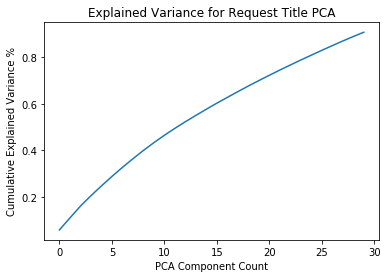

In [32]:
title_pca = PCA(30)
title_pca.fit(train_request_title_wordvecs.todense())
plt.plot(np.cumsum(title_pca.explained_variance_ratio_))
plt.xlabel('PCA Component Count')
plt.ylabel('Cumulative Explained Variance %')
plt.title('Explained Variance for Request Title PCA')
plt.show()

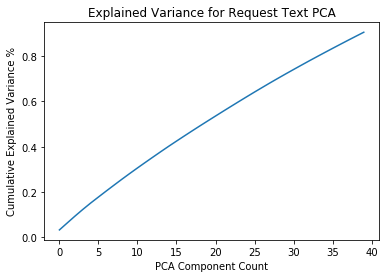

In [33]:
text_pca = PCA(40)
text_pca.fit(train_request_text_wordvecs.todense())
np.cumsum(text_pca.explained_variance_ratio_)

plt.plot(np.cumsum(text_pca.explained_variance_ratio_))
plt.xlabel('PCA Component Count')
plt.ylabel('Cumulative Explained Variance %')
plt.title('Explained Variance for Request Text PCA')
plt.show()

Because PCA does not allow us to cut down significantly on the feature dimensions while still explaining much of the variance, we look to a Random Forest on only the word vector counts in order to identify the most important features. This also serves to prevent overfitting in classifiers like Logistic regression.

So, we fit a Random Forest classifier on the full word-vector list from titles and posts and keep only those with the largest weights after ensembling.

In [34]:
extended_wordvecs = np.concatenate((extended_request_title_wordvecs.toarray(),
                                extended_request_text_wordvecs.toarray()), axis=1)
print("Word vector features:", extended_wordvecs.shape)

train_words = extended_wordvecs[in_train]
dev_words = extended_wordvecs[in_dev]
test_words = extended_wordvecs[in_test]

rf = RandomForestClassifier()
rf.fit(train_words, train_labels)

dev_score = rf.score(dev_words, dev_labels)
dev_probs = rf.predict_proba(dev_words)
print("\nRandom Forest")
print("Development score:", "{:.3f}".format(metrics.roc_auc_score(dev_labels, dev_probs[:,1])))

importance_index = np.argsort(rf.feature_importances_)

top = 100
restricted_wordvecs = extended_wordvecs[:,importance_index[importance_index.shape[0]-top:]]

Word vector features: (5671, 85)

Random Forest
Development score: 0.564


## Final Data Preparation
Now that we've done all our transformations on the "extended" data set, we can replace our raw text fields with our transformed vocabulary and keep only our numeric model features.

We're going to also add in a set of sentiment scores for the two text columns using VADER, which produces four sentiment metrics: positive, neutral and negative, and compound score, which is the sum of all of the lexicon ratings (1.9 and 1.8 in this case) which have been standardised to range between -1 and 1. In our case, compound scores could be negative so we decline to use them.

In [35]:
sid_rt = SentimentIntensityAnalyzer()
sid_t = SentimentIntensityAnalyzer()
sentiment_metrics = ['neg', 'neu', 'pos'] #compound metrics produce negative numbers which we can't use
extended_sentiment_data = pd.DataFrame()
for metrix in sentiment_metrics:
    extended_sentiment_data['request_text_edit_aware_'+ metrix] = extended_data['request_text_edit_aware'].apply(lambda x: sid_rt.polarity_scores(x)[metrix])
    extended_sentiment_data['request_title_'+ metrix] = extended_data['request_title'].apply(lambda x: sid_t.polarity_scores(x)[metrix])
extended_sentiment_data.head(8)

,request_text_edit_aware_neg,request_title_neg,request_text_edit_aware_neu,request_title_neu,request_text_edit_aware_pos,request_title_pos
0,0.025,0.000,0.836,0.444,0.139,0.556
1,0.322,0.216,0.678,0.784,0.000,0.000
2,0.000,0.000,0.867,0.667,0.133,0.333
3,0.086,0.000,0.733,1.000,0.180,0.000
4,0.065,0.000,0.677,0.596,0.258,0.404
5,0.097,0.000,0.684,1.000,0.219,0.000
6,0.051,0.000,0.788,0.769,0.161,0.231
7,0.090,0.000,0.743,1.000,0.167,0.000


In [36]:
model_data = extended_data.copy()

exclude_features = ['giver_username_if_known', 'request_id', 'request_text_edit_aware',
                    'request_title','requester_subreddits_at_request','requester_username',
                    'requester_upvotes_minus_downvotes_at_request']

model_data = model_data.drop(exclude_features, axis=1)

#extended_request_text_wordvecs = request_text_vectorizer.transform(extended_data['request_text_edit_aware'])
#extended_request_title_wordvecs = request_title_vectorizer.transform(extended_data['request_title'])


model_data = np.concatenate((model_data, extended_sentiment_data,restricted_wordvecs), axis=1)
print(extended_wordvecs.shape)
print(model_data.shape)

(5671, 85)
(5671, 42)


Now that we've done all our transformations on the "extended" data set, we will split it back up into train, dev, and test.

In [37]:
train_data = model_data[in_train]
dev_data = model_data[in_dev]
test_data = model_data[in_test]

print("Train:", train_data.shape, "Development:", dev_data.shape, "Test:", test_data.shape)

Train: (3443, 42) Development: (597, 42) Test: (1631, 42)


# Modeling

### Logistic Regression
We begin modeling with training a series of logistic regression models on our generated word counts and other numeric variables, including log transformations and vote ratios, for hyperparameters C and lasso regularization. The continuous nature of the features and the likely interactions between them potentially lend credence to logistic estimation.

Logistic with c = 0.0001 and l1 regularization:
train ROC: 0.609
dev ROC:   0.600
******************************
Logistic with c = 0.001 and l1 regularization:
train ROC: 0.617
dev ROC:   0.609
******************************
Logistic with c = 0.005 and l1 regularization:
train ROC: 0.644
dev ROC:   0.611
******************************
Logistic with c = 0.01 and l1 regularization:
train ROC: 0.645
dev ROC:   0.616
******************************
Logistic with c = 0.025 and l1 regularization:
train ROC: 0.661
dev ROC:   0.640
******************************
Logistic with c = 0.05 and l1 regularization:
train ROC: 0.668
dev ROC:   0.654
******************************
Logistic with c = 0.1 and l1 regularization:
train ROC: 0.673
dev ROC:   0.657
******************************
Logistic with c = 0.125 and l1 regularization:
train ROC: 0.675
dev ROC:   0.658
******************************
Logistic with c = 0.25 and l1 regularization:
train ROC: 0.680
dev ROC:   0.657
***************************

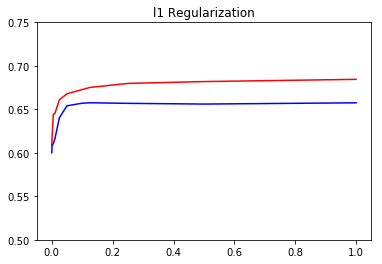

Logistic with c = 0.0001 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.001 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.005 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.01 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.025 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.05 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.1 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.125 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
******************************
Logistic with c = 0.25 and l2 regularization:
train ROC: 0.579
dev ROC:   0.549
***************************

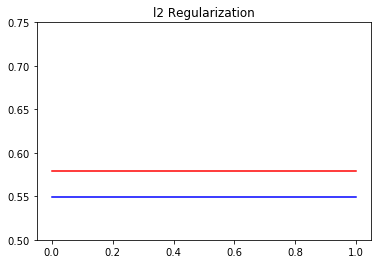

Best development ROC: 0.658 (c= 0.125 , reg= l1 )
For train:
              precision    recall  f1-score   support

      False       0.68      0.83      0.75      2150
       True       0.56      0.37      0.44      1293

avg / total       0.64      0.65      0.63      3443

For dev:
              precision    recall  f1-score   support

      False       0.66      0.81      0.73       367
       True       0.53      0.34      0.42       230

avg / total       0.61      0.63      0.61       597



In [38]:
def logistic_tester(c=1, p="l2", 
                    train_data = train_data,
                    train_labels = train_labels,
                    dev_data = dev_data,
                    dev_labels = dev_labels,
                    test_data = test_data):
    """Train logistic for any C, penalty; return ROC score on development set and test set predictions"""
    
    print("Logistic with c =", str(c), "and", p,"regularization:")
    full_lr = LogisticRegression(penalty=p, C=c, tol=.001, class_weight="balanced")
    full_lr.fit(train_data, train_labels)

    train_preds = full_lr.predict(train_data)
    train_probs = full_lr.predict_proba(train_data)
    train_ROC = metrics.roc_auc_score(train_labels, train_probs[:,1])

    dev_preds = full_lr.predict(dev_data)
    dev_probs = full_lr.predict_proba(dev_data)
    dev_ROC = metrics.roc_auc_score(dev_labels, dev_probs[:,1])

    #Misclassified
    misclassified_lr = np.where(dev_labels != dev_preds)
    
    test_preds = full_lr.predict(test_data)
    
    print("train ROC:", "{:.3f}".format(train_ROC))
    print("dev ROC:  ", "{:.3f}".format(dev_ROC))
    
    print("*"*30)
    return train_ROC, dev_ROC, test_preds, misclassified_lr, train_preds, dev_preds


c_list = [.0001, .001, .005, .01, .025, .05, .1, .125, .25, .5, 1]
reg = ["l1","l2"]

best_dev_roc = 0

for r in reg:
    train_scores = []
    dev_scores = []
    for c in c_list:
        train_ROC, dev_ROC, test_out, misclassified_lr, train_preds, dev_preds = logistic_tester(c=c, p=r)
        if (dev_ROC > best_dev_roc):
            best_dev_roc = dev_ROC
            test_preds = test_out
            best_c = c
            best_reg = r
            best_train_preds, best_dev_preds = train_preds, dev_preds
        train_scores.append(train_ROC)
        dev_scores.append(dev_ROC)
    plt.plot(c_list, train_scores, "r", c_list, dev_scores, "b")
    plt.title(r+" Regularization")
    plt.ylim(.5,.75)
    plt.show()

print("Best development ROC:", "{:.3f}".format(best_dev_roc), "(c=", best_c,", reg=", best_reg, ")")

print("For train:\n", classification_report(best_train_preds, train_labels))
print("For dev:\n", classification_report(best_dev_preds, dev_labels))

In [39]:
def export_test_preds(test_preds=test_preds, model="X"):
    test_out = pd.DataFrame()
    test_out['request_id'] = extended_data[in_test]['request_id']
    test_out['requester_received_pizza'] = test_preds.astype(int)
    test_out.to_csv('./data/submission_'+model+'.csv', index=False)
    return None

#export_test_preds(test_preds, "logit")

### Logistic with AdaBoost
With lots of room for potential improvement over the original logistic based on the missed true positives, we try using AdaBoost to bump up the scale, to no avail.

In [43]:
ada = AdaBoostClassifier(LogisticRegression(penalty="l1", C=0.1, tol=.001))
ada.fit(train_data, train_labels)

train_preds = ada.predict(train_data)
train_probs = ada.predict_proba(train_data)
train_ROC = metrics.roc_auc_score(train_labels, train_probs[:,1])

dev_preds = ada.predict(dev_data)
dev_probs = ada.predict_proba(dev_data)
dev_ROC = metrics.roc_auc_score(dev_labels, dev_probs[:,1])

test_preds = ada.predict(test_data)

print("train ROC:", "{:.3f}".format(train_ROC))
print("dev ROC:  ", "{:.3f}".format(dev_ROC))

train ROC: 0.607
dev ROC:   0.605


### Multinomial Naive Bayes
We next try using the Naive Bayes classifier, varying the hyperparameter of alpha and comparing its ROC score on our development set to that of the logistic regression.

Naive Bayes with a = 0.0001 :
train ROC: 0.528859988074
dev ROC: 0.505316927666
******************************

Naive Bayes with a = 0.001 :
train ROC: 0.528859988074
dev ROC: 0.505316927666
******************************

Naive Bayes with a = 0.01 :
train ROC: 0.528859988074
dev ROC: 0.505316927666
******************************

Naive Bayes with a = 0.1 :
train ROC: 0.528859988074
dev ROC: 0.505316927666
******************************

Naive Bayes with a = 0.5 :
train ROC: 0.528859988074
dev ROC: 0.505316927666
******************************

Naive Bayes with a = 1.0 :
train ROC: 0.528859988074
dev ROC: 0.505316927666
******************************



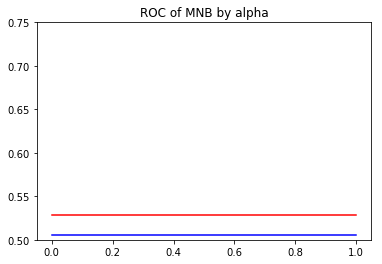

Best development ROC: 0.505316927666 (a= 0.0001 )


In [44]:
def nb_tester(a=1, 
                train_data = train_data,
                train_labels = train_labels,
                dev_data = dev_data,
                dev_labels = dev_labels,
                test_data = test_data):
    """Train Multi NB for any alpha a; return ROC score on development set and test set predictions"""
    
    print("Naive Bayes with a =", str(a),":")
    full_nb = MultinomialNB(alpha=a)
    full_nb.fit(train_data, train_labels)

    train_preds = full_nb.predict(train_data)
    train_probs = full_nb.predict_proba(train_data)
    train_ROC = metrics.roc_auc_score(train_labels, train_probs[:,1])

    dev_preds = full_nb.predict(dev_data)
    dev_probs = full_nb.predict_proba(dev_data)
    dev_ROC = metrics.roc_auc_score(dev_labels, dev_probs[:,1])
    
    #misclassified
    misclassified_mnb = np.where(dev_labels != dev_preds)
    
    test_preds = full_nb.predict(test_data)

    print("train ROC:", train_ROC)
    print("dev ROC:", dev_ROC)

    #print(classification_report(train_preds, train_labels))
    #print(classification_report(dev_preds, dev_labels))
    
    print("*"*30+"\n")
    return train_ROC, dev_ROC, test_preds, misclassified_mnb

a_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]

best_dev_roc = 0

train_scores = []
dev_scores = []
for a in a_list:
    train_ROC, dev_ROC, test_out, misclassified_mnb = nb_tester(a=a)
    if (dev_ROC > best_dev_roc):
        best_dev_roc = dev_ROC
        test_preds = test_out
        best_a = a
    train_scores.append(train_ROC)
    dev_scores.append(dev_ROC)
plt.plot(a_list, train_scores, "r", a_list, dev_scores, "b")
plt.title("ROC of MNB by alpha")
plt.ylim(.50,.75)
plt.show()

print("Best development ROC:", best_dev_roc, "(a=", best_a,")")

In [45]:
#export_test_preds(test_preds, "gnb")

Given the presence of numeric features including log-transformations, we consider a Gaussian NB, but like the Multinomial NB for different values of alpha, the classifier struggles to predict true positives.

In [46]:
def gnb_tester(train_data = train_data,
                train_labels = train_labels,
                dev_data = dev_data,
                dev_labels = dev_labels,
                test_data = test_data):
    """Train Gaussian NB; return ROC score on development set and test set predictions"""
    
    print("Gaussian Naive Bayes:")
    gnb = GaussianNB()
    gnb.fit(train_data, train_labels)

    train_preds = gnb.predict(train_data)
    train_probs = gnb.predict_proba(train_data)
    train_ROC = metrics.roc_auc_score(train_labels, train_probs[:,1])

    dev_preds = gnb.predict(dev_data)
    dev_probs = gnb.predict_proba(dev_data)
    dev_ROC = metrics.roc_auc_score(dev_labels, dev_probs[:,1])
    
    #misclassified
    misclassified_gnb = np.where(dev_labels != dev_preds)
    
    test_preds = gnb.predict(test_data)

    print("Training set:\n", classification_report(train_preds, train_labels))
    print("Development set:\n", classification_report(dev_preds, dev_labels))
    
    return train_ROC, dev_ROC, test_preds, misclassified_gnb


train_ROC, dev_ROC, test_out, misclassified_gnb = gnb_tester()

print("GNB train ROC:      ", train_ROC)
print("GNB development ROC:", dev_ROC)

Gaussian Naive Bayes:
Training set:
              precision    recall  f1-score   support

      False       0.99      0.76      0.86      3399
       True       0.01      0.27      0.03        44

avg / total       0.98      0.75      0.85      3443

Development set:
              precision    recall  f1-score   support

      False       0.99      0.75      0.85       590
       True       0.01      0.29      0.03         7

avg / total       0.98      0.74      0.84       597

GNB train ROC:       0.580307272757
GNB development ROC: 0.600462341536


### Gaussian Mixture Model
Lastly, we consider a GMM built on both the received and did-not-receive groups, thinking that there may be clusters of types of requesters who may have similar likelihoods of receiving. However, much like NB, it still over-predicts did-not-receive and struggles to identify the true positives.

In [47]:
def gmm_tester(pca_comp=10, n_comp=5, covar="full",
               train_data = train_data,
               train_labels = train_labels,
               dev_data = dev_data,
               dev_labels = dev_labels,
               test_data = test_data):
    """Train GMM for n components and each covariance matrix;
        return ROC score on development set and test set predictions"""
    
    #print(str(pca_comp),"PCA components,", str(n_comp), "GMM components,", covar)
    pca = PCA(n_components=pca_comp)
    train_data2 = pca.fit_transform(train_data)
    dev_data2 = pca.transform(dev_data)
    test_data2 = pca.transform(test_data)
    
    train_pos, train_neg = train_data2[train_labels == 1], train_data2[train_labels == 0]
    
    gmm_pos = GaussianMixture(n_components=n_comp, covariance_type=covar)
    gmm_pos.fit(train_pos)
    train_pos = gmm_pos.score_samples(train_data2)
    dev_pos = gmm_pos.score_samples(dev_data2)
    test_pos = gmm_pos.score_samples(test_data2)
    
    gmm_neg = GaussianMixture(n_components=n_comp, covariance_type=covar)
    gmm_neg.fit(train_neg)
    train_neg = gmm_neg.score_samples(train_data2)
    dev_neg = gmm_neg.score_samples(dev_data2)
    test_neg = gmm_neg.score_samples(test_data2)
    
    train_preds = np.zeros(train_pos.shape)
    train_preds = (train_pos > train_neg).astype(int)
    #train_scores = np.exp(train_pos)/(np.exp(train_pos) + np.exp(train_neg))
    train_accuracy = np.sum(train_labels == train_preds) / len(train_labels)

    
    dev_preds = np.zeros(dev_pos.shape)
    dev_preds = (dev_pos > dev_neg).astype(int)
    #dev_scores = np.exp(dev_pos)/(np.exp(dev_pos) + np.exp(dev_neg))
    dev_accuracy = np.sum(dev_labels == dev_preds) / len(dev_labels)
    
    #misclassified
    misclassified_gmm = np.where(dev_preds != dev_labels)
    
    #print("train accuracy:", "{:.3f}".format(train_accuracy))
    #print("dev accuracy:  ", "{:.3f}".format(dev_accuracy))
    #print()
    
    test_preds = np.zeros(test_pos.shape)
    test_preds = (test_pos > test_neg).astype(int)
    
    #print(classification_report(train_preds, train_labels))
    #print(classification_report(dev_preds, dev_labels))
    
    return train_accuracy, dev_accuracy, test_preds, misclassified_gmm

#gmm_tester()


pca_comps = [5*i for i in range(1,5)]
n_comps = [i for i in range(2,11)]
cov = ['full', 'tied', 'diag', 'spherical']

best_dev_accuracy = 0
for p in pca_comps:
    #train_scores = []
    #dev_scores = []
    for n in n_comps:
        for c in cov:
            train_accuracy, dev_accuracy, test_out, misclassified_gmm = gmm_tester(p, n, c)
            if (dev_accuracy > best_dev_accuracy):
                best_dev_accuracy = dev_accuracy
                test_preds = test_out
                best_p = p
                best_n = n
                best_c = c
                
            #train_scores.append(train_ROC)
            #dev_scores.append(dev_ROC)
        #plt.plot(n_comps, train_scores, "r", n_comps, dev_scores, "b")
        #plt.title(str(p)+" Components")
        #plt.ylim(.5,1)
        #plt.show()
print("Best development accuracy:", "{:.3f}".format(best_dev_accuracy), "(PCA=", best_p,", N=", best_n,", cov=", best_c,")")

Best development accuracy: 0.754 (PCA= 15 , N= 10 , cov= tied )


The best performing GMM, with 15 PCA components, 10 GMM components, and a tied covariance matrix, performs poorly on the test dataset, with an ROC close to 50%.

In [48]:
#export_test_preds(test_preds, "gmm")

## Error Checking

In [49]:
misclassified_lr
misclassified_gnb
misclassified_mnb
misclassified_gmm

(array([  0,   6,   7,  12,  17,  23,  25,  26,  28,  32,  33,  34,  35,
         40,  41,  44,  47,  48,  49,  54,  55,  57,  59,  63,  64,  65,
         70,  71,  72,  74,  75,  77,  78,  80,  82,  86,  88,  90,  95,
         96,  97,  98, 102, 104, 105, 108, 109, 110, 111, 115, 117, 118,
        120, 122, 125, 126, 127, 128, 130, 132, 133, 139, 141, 143, 146,
        147, 148, 151, 155, 156, 157, 160, 161, 165, 166, 167, 170, 173,
        174, 176, 178, 179, 182, 183, 185, 186, 187, 190, 191, 194, 195,
        196, 197, 200, 201, 203, 205, 207, 209, 216, 218, 220, 221, 225,
        228, 230, 231, 233, 241, 243, 245, 249, 250, 252, 255, 257, 262,
        263, 267, 269, 273, 274, 275, 276, 279, 280, 282, 285, 286, 287,
        288, 292, 293, 296, 297, 300, 302, 303, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 319, 323, 324, 326, 327, 328, 330, 331, 334,
        335, 337, 338, 340, 342, 343, 350, 353, 354, 355, 357, 359, 361,
        362, 363, 365, 367, 372, 374, 375, 378, 380

In [50]:
misclassified_intersect = np.intersect1d(misclassified_lr, misclassified_gnb)
misclassified_intersect = np.intersect1d(misclassified_intersect, misclassified_mnb)
misclassified_intersect = np.intersect1d(misclassified_intersect, misclassified_gmm)
misclassified_intersect

array([  7,  25,  34,  44,  65,  70,  71,  90,  97, 109, 110, 126, 143,
       155, 167, 179, 191, 196, 197, 216, 231, 255, 257, 267, 288, 300,
       302, 309, 312, 316, 328, 331, 353, 355, 363, 365, 367, 386, 387,
       391, 397, 422, 437, 439, 450, 456, 470, 473, 498, 504, 520, 527,
       535, 545, 556, 592, 594, 596], dtype=int64)

Let's look now at the unique misclassification rates per model to learn how each model performed

In [52]:
common_misclassification_count = len(misclassified_intersect)
misclass_list = [misclassified_lr, misclassified_mnb, misclassified_gnb, misclassified_gmm]
misclass_list_name = ['misclassified_lr', 'misclassified_mnb', 'misclassified_gnb', 'misclassified_gmm']
for i in misclass_list:
    print("{} had a {:.3f}% unique error rate".format(misclass_list_name[misclass_list.index(i)], len(np.setdiff1d(i, misclassified_intersect))/common_misclassification_count))

misclassified_lr had a 2.069% unique error rate
misclassified_mnb had a 2.517% unique error rate
misclassified_gnb had a 1.638% unique error rate
misclassified_gmm had a 3.793% unique error rate


C:\Users\Colby\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


GMM, to no surprise, had the most difficult and unique errors at 10% given how it doesn't perform well with word vectors as word2vec numerical values aren't generally normally distributed hence difficult to model.

In [61]:
dev_data_extended = extended_data[in_dev]
true_labels = dev_labels[misclassified_intersect]
most_common_misclassfied = pd.concat([dev_data_extended[["request_title", "request_text_edit_aware"]].iloc[misclassified_intersect], true_labels], axis = 1) 
most_common_misclassfied[70:]

,request_title,request_text_edit_aware,requester_received_pizza
967,"(Request) Dinner in Pacific, Mo?",Hi everyone. I usually just lurk around reddit...,NaN
1033,"[Request] Broke until payday. Lubbock, Texas",All I have to get me through until Friday is a...,NaN
1112,[Request] I have been craving Pizza for two we...,"Hi, I am a married college student with no job...",NaN
1176,[Request] Broke student. I have little money a...,Proof: http://imgur.com/7UrIW\n\nAny size pizz...,NaN
1267,"[REQUEST]Old friend in town, no food in house....",Hello RAOP\n\nI have an old friend in town thi...,NaN
1283,[REQUEST] Not much food until tomorrow.,I will go ahead and say that I got a pizza mea...,NaN
1286,"[Request] I just lost my job, short on rent :(",Yesterday I got laid off with a job I've been ...,NaN
1407,[Request] US Married couple in between jobs wo...,(Tennessee USA) It is a day to celebrate after...,NaN
1485,"[REQUEST] Hungry dad with no food in Kent, WA","Hello everyone,\n\nThis is my first time here,...",NaN
1669,"[Request] No money until Friday, could use a p...",Hi RAoP! \nI live in Miami and have been short...,NaN


In [79]:
most_common_misclassfied.to_csv('./data/most_common_misclassified.csv', index=False)

After reading the most common misclassified CSV, most of the fulfilled requests that our models missed were financially related unfortunate events - paycheck to paycheck, unemployed, recently laid off, college/grad school income, followed by personal relational events - pregnant, relocation, lonely, heartbreak, divorce.